# Custom Model Implementation

### Details 

TODO

## Import, preprocess and split Data 

In [14]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import resample

from seiz_eeg.dataset import EEGDataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from data.dataset import EEGDatasetWrapper

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

import wandb
from tqdm import tqdm


import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
data_root = "data/data"
data_preprocessing = "fft_filtering"
data_preprocessing_time = "downsample"
eeg_data_wrapper_freq = EEGDatasetWrapper(
    data_root,
    data_preprocessing)
eeg_data_wrapper_time = EEGDatasetWrapper(
    data_root,
    data_preprocessing_time)


In [16]:
selected_ids = eeg_data_wrapper_time.get_subject_ids()
validation_id = "s002" 
selected_ids.remove(validation_id)
train_dataset_freq, val_dataset_freq = eeg_data_wrapper_freq.leave_one_out_split(
        validation_id, selected_ids
    )
train_dataset_time, val_dataset_time = eeg_data_wrapper_time.leave_one_out_split(
        validation_id, selected_ids
    )

# split train_dataset 30-70 
train_edge_prediction_model_size = int(0.6 * len(train_dataset_freq))
train_seizure_classifier_size = len(train_dataset_freq) - train_edge_prediction_model_size
train_edge_prediction_dataset_freq, train_seizure_classifier_dataset_freq = random_split(
    train_dataset_freq,
    [train_edge_prediction_model_size, train_seizure_classifier_size],
)
train_edge_prediction_dataset_time, train_seizure_classifier_dataset_time = random_split(
    train_dataset_time,
    [train_edge_prediction_model_size, train_seizure_classifier_size],
)

In [17]:
labels_edge_pred = train_edge_prediction_dataset_freq.dataset.get_label_array()
labels_eeg_classifier = train_seizure_classifier_dataset_freq.dataset.get_label_array()
labels_edge_pred = np.array(labels_edge_pred)
labels_eeg_classifier = np.array(labels_eeg_classifier)
print("Edge prediction dataset label ratio")
print("0: ", len(labels_edge_pred[labels_edge_pred == 0]) / len(labels_edge_pred))
print("Seizure classifier dataset label ratio")
print("0: ", len(labels_eeg_classifier[labels_eeg_classifier == 0]) / len(labels_eeg_classifier))


Edge prediction dataset label ratio
0:  0.8001716083516065
Seizure classifier dataset label ratio
0:  0.8001716083516065


In [18]:
train_edge_pred_loader = DataLoader(
        train_edge_prediction_dataset_time, batch_size=32, shuffle=True
    )
train_seizure_class_loader = DataLoader(
        train_seizure_classifier_dataset_time, batch_size=32, shuffle=True
    )
val_loader = DataLoader(val_dataset_time, batch_size=32,shuffle = True)

train_edge_pred_loader_freq = DataLoader(
        train_edge_prediction_dataset_freq, batch_size=32, shuffle=True
    )
train_seizure_class_loader_freq = DataLoader(
        train_seizure_classifier_dataset_freq, batch_size=32, shuffle=True
    )
val_loader_freq = DataLoader(val_dataset_freq, batch_size=32,shuffle = True)


## Build Graph Generator Model

In [19]:
class EEG_Graph_Builder(nn.Module):
    def __init__(self, lstm_hidden_dim=80, lstm_layers=4, lstm_bidirectional=True):
        super(EEG_Graph_Builder, self).__init__()
        self.num_electrodes = 19
        self.bidirectional = lstm_bidirectional
        self.lstm_hidden_dim = lstm_hidden_dim
        self.output_dim = lstm_hidden_dim * (2 if lstm_bidirectional else 1)

        self.lstm = nn.LSTM(
            input_size=1,
            hidden_size=lstm_hidden_dim,
            num_layers=lstm_layers,
            batch_first=True,
            bidirectional=lstm_bidirectional,
            dropout=0.2 if lstm_layers > 1 else 0.0
        )

    def forward(self, x):
        # x: (batch, seq_len, num_electrodes)
        batch_size, seq_len, num_electrodes = x.shape
        assert num_electrodes == self.num_electrodes, "Input should have 19 electrodes"

        # Prepare electrode inputs: list of tensors (batch, seq_len, 1)
        electrode_embeddings = []
        for i in range(num_electrodes):
            electrode_input = x[:, :, i].unsqueeze(-1)  # (batch, seq_len, 1)
            _, (h_n, _) = self.lstm(electrode_input)    # h_n: (num_layers * num_directions, batch, hidden_dim)
            h_n = h_n.transpose(0, 1).reshape(batch_size, -1)  # (batch, hidden_dim * directions)
            electrode_embeddings.append(h_n)

        # Stack embeddings: (batch, num_electrodes, embedding_dim)
        electrode_embeddings = torch.stack(electrode_embeddings, dim=1)

        # Normalize embeddings
        normalized = F.normalize(electrode_embeddings, p=2, dim=2)

        # Compute cosine similarity matrix: (batch, num_electrodes, num_electrodes)
        adjacency = torch.bmm(normalized, normalized.transpose(1, 2))

        # Optional: mean pooling over upper triangular (excluding self-similarities)
        mask = torch.triu(torch.ones(self.num_electrodes, self.num_electrodes), diagonal=1).to(x.device)
        mask = mask.unsqueeze(0)  # (1, 19, 19)
        total_edges = mask.sum()
        pooled = (adjacency * mask).sum(dim=(1, 2)) / total_edges  # (batch,)

        return adjacency, pooled  # (batch, 19, 19), (batch,)


In [25]:
import torch
import torch.nn as nn

class EEG_Analyser(nn.Module):
    def __init__(self, lstm_hidden_dim=80, lstm_layers=4, lstm_bidirectional=True):
        super(EEG_Analyser, self).__init__()
        self.num_electrodes = 19
        self.bidirectional = lstm_bidirectional
        self.lstm_hidden_dim = lstm_hidden_dim
        self.output_dim = self.output_dim = lstm_hidden_dim * lstm_layers * (2 if lstm_bidirectional else 1)


        self.lstm = nn.LSTM(
            input_size=1,
            hidden_size=lstm_hidden_dim,
            num_layers=lstm_layers,
            batch_first=True,
            bidirectional=lstm_bidirectional,
            dropout=0.2 if lstm_layers > 1 else 0.0
        )

        # Binary classification head
        self.fc = nn.Linear(self.output_dim, 1)
        self.sigmoid = nn.Sigmoid()  # Optional if using BCEWithLogitsLoss

    def forward(self, x):
        # x: (batch, seq_len, num_electrodes)
        batch_size, seq_len, num_electrodes = x.shape
        assert num_electrodes == self.num_electrodes, "Input should have 19 electrodes"

        # Process each electrode individually
        electrode_embeddings = []
        for i in range(num_electrodes):
            electrode_input = x[:, :, i].unsqueeze(-1)  # (batch, seq_len, 1)
            _, (h_n, _) = self.lstm(electrode_input)    # h_n: (num_layers * num_directions, batch, hidden_dim)
            h_n = h_n.transpose(0, 1).reshape(batch_size, -1)  # (batch, hidden_dim * directions)
            electrode_embeddings.append(h_n)

        # Stack and pool across electrodes
        electrode_embeddings = torch.stack(electrode_embeddings, dim=1)  # (batch, num_electrodes, embedding_dim)
        pooled = electrode_embeddings.mean(dim=1)  # (batch, embedding_dim)

        # Binary classification
        out = self.fc(pooled)           # (batch, 1)
        
        return out


## Train model

DON'T RUN IF ALREADY TRAINED

In [21]:
class BinaryFocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'):
        """
        alpha: weight for class 1
        gamma: focusing parameter
        reduction: 'mean', 'sum' or 'none'
        """
        super(BinaryFocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, logits, labels):
        """
        logits: raw model output (before sigmoid), shape (batch,)
        labels: ground truth labels (0 or 1), shape (batch,)
        """
        probs = torch.sigmoid(logits)
        probs = probs.clamp(min=1e-7, max=1 - 1e-7)  # numerical stability
        labels = labels.float()

        p_t = probs * labels + (1 - probs) * (1 - labels)
        alpha_t = self.alpha * labels + (1 - self.alpha) * (1 - labels)

        focal_term = (1 - p_t) ** self.gamma
        loss = -alpha_t * focal_term * torch.log(p_t + 1e-9)

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        return loss

In [36]:
class HingeLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(HingeLoss, self).__init__()
        self.margin = margin

    def forward(self, logits, labels):
        """
        logits: raw model output (before sigmoid), shape (batch,)
        labels: ground truth labels (0 or 1), shape (batch,)
        """
        labels = labels.float()
        loss = torch.mean(torch.clamp(self.margin - logits * (2 * labels - 1), min=0))
        return loss

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 5
model = EEG_Graph_Builder().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = BinaryFocalLoss(alpha=0.75, gamma=2.0, reduction='mean')

wandb.init(
    project="EEG_Graph_Builder",  # give your project a name
    config={
        "epochs": num_epochs,
        "learning_rate": 1e-3,
        "loss": "BinaryFocalLoss",
        "alpha": 0.75,
        "gamma": 2.0,
        "model": "EEG_Graph_Builder"
    }
)


for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    loop = tqdm(train_edge_pred_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
    for step, (x_batch, y_batch) in enumerate(loop):
        x_batch = x_batch.to(device).float()
        y_batch = y_batch.to(device)

        _, logits = model(x_batch)
        loss = loss_fn(logits, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        avg_loss = running_loss / (step + 1)

        loop.set_postfix(loss=avg_loss)
        wandb.log({"batch_loss": loss.item(), "avg_loss": avg_loss, "epoch": epoch + 1})




wandb: Currently logged in as: cboissier77 (cboissier77-epfl) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 5
model_freq = EEG_Analyser().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = BinaryFocalLoss(alpha=0.75, gamma=2.0, reduction='mean')

wandb.init(
    project="EEG_Analyser_Freq",  # give your project a name
    config={
        "epochs": num_epochs,
        "learning_rate": 1e-3,
        "loss": "BinaryFocalLoss",
        "alpha": 0.75,
        "gamma": 2.0,
        "model": "EEG_Graph_Builder"
    }
)


for epoch in range(num_epochs):
    model_freq.train()
    running_loss = 0.0

    loop = tqdm(train_edge_pred_loader_freq, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
    for step, (x_batch, y_batch) in enumerate(loop):
        x_batch = x_batch.to(device).float()
        y_batch = y_batch.to(device)

        logits = model_freq(x_batch)
        loss = loss_fn(logits, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        avg_loss = running_loss / (step + 1)

        loop.set_postfix(loss=avg_loss)
        wandb.log({"batch_loss": loss.item(), "avg_loss": avg_loss, "epoch": epoch + 1})



Epoch 1/5:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 194/197 [34:13<00:34, 11.55s/it, loss=0.0604]wandb: WARNING Fatal error while uploading data. Some run data will not be synced, but it will still be written to disk. Use `wandb sync` at the end of the run to try uploading.


In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 5
model_time = EEG_Analyser().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = BinaryFocalLoss(alpha=0.75, gamma=2.0, reduction='mean')

wandb.init(
    project="EEG_Analyser_Time",  # give your project a name
    config={
        "epochs": num_epochs,
        "learning_rate": 1e-3,
        "loss": "BinaryFocalLoss",
        "alpha": 0.75,
        "gamma": 2.0,
        "model": "EEG_Graph_Builder"
    }
)


for epoch in range(num_epochs):
    model_time.train()
    running_loss = 0.0

    loop = tqdm(train_edge_pred_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
    for step, (x_batch, y_batch) in enumerate(loop):
        x_batch = x_batch.to(device).float()
        y_batch = y_batch.to(device)

        logits = model_time(x_batch)
        loss = loss_fn(logits, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        avg_loss = running_loss / (step + 1)

        loop.set_postfix(loss=avg_loss)
        wandb.log({"batch_loss": loss.item(), "avg_loss": avg_loss, "epoch": epoch + 1})

avg_loss,▄▄▂▃▃▃▃▃▁▄▄▄▄▃▃▃▃▃█▅▅▅▄▃▄▃▆▆▅▄▃▃▃▃▃▃▃▃▃▃
batch_loss,▄▆▄▅▄▃▄▅█▃▇▅▃▄▃▄▂▆▄▅▄▃▄▃▃▅▄▄▅▃▅▅▁▄▅▂▃▄▃▄
epoch,▁▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆██████
avg_loss,0.06028
batch_loss,0.07187
epoch,5


wandb: WARNING Fatal error while uploading data. Some run data will not be synced, but it will still be written to disk. Use `wandb sync` at the end of the run to try uploading.


In [30]:
# save the model
#torch.save(model.state_dict(), "eeg_graph_builder.pth")
#torch.save(model_freq.state_dict(), "eeg_analyser_freq.pth")
torch.save(model_time.state_dict(), "eeg_analyser_time.pth")

In [31]:
# load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EEG_Graph_Builder().to(device)
model.load_state_dict(torch.load("eeg_graph_builder.pth"))
model_freq = EEG_Analyser().to(device)
model_freq.load_state_dict(torch.load("eeg_analyser_freq.pth"))
model_time = EEG_Analyser().to(device)
model_time.load_state_dict(torch.load("eeg_analyser_time.pth"))

<All keys matched successfully>

In [34]:
model.eval()
model_time.eval()
model_freq.eval()
all_preds = []
all_preds_freq = []
all_preds_time = []
all_probs = []
all_probs_freq = []
all_probs_time = []
all_labels = []



with torch.no_grad():
    loop = tqdm(train_edge_pred_loader_freq, desc="Validation", leave=False)
    for x_val, y_val in loop:
        x_val = x_val.to(device).float()
        y_val = y_val.to(device)

        adjacency, logits = model(x_val)  # logits: (batch,), raw scores
        probs = torch.sigmoid(logits)  # Apply sigmoid to get probabilities
        all_probs.append(probs.cpu())
        preds = (probs > 0.5).long()      # Binary prediction threshold
        all_preds.append(preds.cpu())
        logits_freq = model_freq(x_val)
        probs_freq = torch.sigmoid(logits_freq)
        all_probs_freq.append(probs_freq.cpu())
        preds_freq = (probs_freq > 0.5).long()
        all_preds_freq.append(preds_freq.cpu())
        logits_time = model_time(x_val)
        probs_time = torch.sigmoid(logits_time)
        all_probs_time.append(probs_time.cpu())
        preds_time = (probs_time > 0.5).long()
        all_preds_time.append(preds_time.cpu())
        all_labels.append(y_val.cpu())



# Stack tensors
all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)
all_preds_freq = torch.cat(all_preds_freq)
all_preds_time = torch.cat(all_preds_time)
all_probs = torch.cat(all_probs)
all_probs_freq = torch.cat(all_probs_freq)
all_probs_time = torch.cat(all_probs_time)

# Print ratio of predicted classes
print("Validation set predicted class ratio:")
print("Class 0:", (all_preds == 0).float().mean().item())
print("Class 1:", (all_preds == 1).float().mean().item())

# Print ratio of predicted classes
print("Validation set predicted class ratio freq:")
print("Class 0:", (all_preds_freq == 0).float().mean().item())
print("Class 1:", (all_preds_freq == 1).float().mean().item())
print("Validation set predicted class ratio time:")
print("Class 0:", (all_preds_time == 0).float().mean().item())
print("Class 1:", (all_preds_time == 1).float().mean().item())

# Metrics
print("Validation Accuracy:", accuracy_score(all_labels, all_preds))
print("F1 Score:", f1_score(all_labels, all_preds))
print("AUROC:", roc_auc_score(all_labels, all_probs))  # Use probs, not preds

print("Validation Accuracy freq:", accuracy_score(all_labels, all_preds_freq))
print("F1 Score freq:", f1_score(all_labels, all_preds_freq))
print("AUROC freq:", roc_auc_score(all_labels, all_probs_freq))  # Use probs, not preds

print("Validation Accuracy time:", accuracy_score(all_labels, all_preds_time))
print("F1 Score time:", f1_score(all_labels, all_preds_time))
print("AUROC time:", roc_auc_score(all_labels, all_probs_time))  # Use probs, not preds



Validation set predicted class ratio:
Class 0: 0.0
Class 1: 1.0
Validation set predicted class ratio freq:
Class 0: 0.9974575042724609
Class 1: 0.002542507601901889
Validation set predicted class ratio time:
Class 0: 0.002542507601901889
Class 1: 0.9974575042724609
Validation Accuracy: 0.20133481646273638
F1 Score: 0.3351851851851852
AUROC: 0.5388034313126595
Validation Accuracy freq: 0.7961226759891944
F1 Score freq: 0.0
AUROC freq: 0.3835137003446325
Validation Accuracy time: 0.20387732401080566
F1 Score time: 0.33589607635206786
AUROC time: 0.6303039506327162


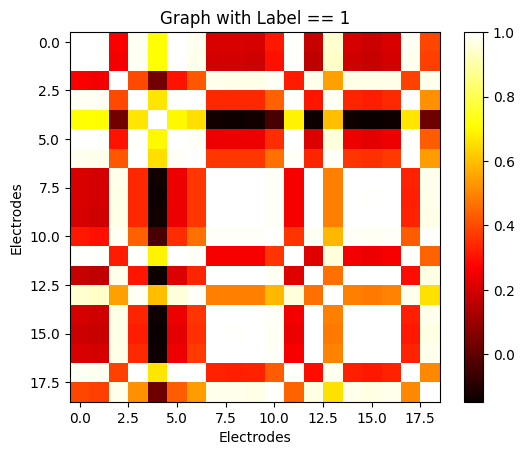

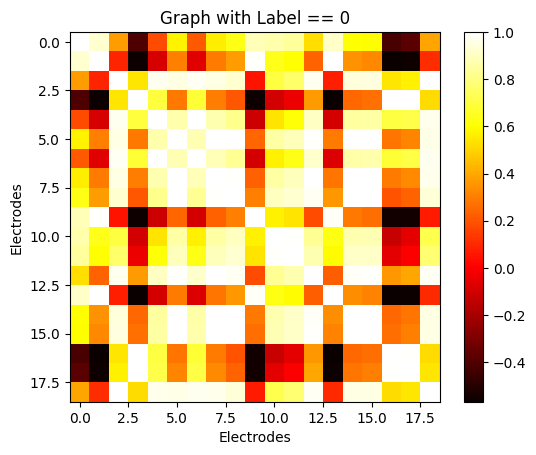

In [41]:
# Find one graph for each label

idx_pos = (all_labels == 1).nonzero(as_tuple=True)[0][5]
idx_neg = (all_labels == 0).nonzero(as_tuple=True)[0][30]

def plot_adj(adj_matrix, title):
    plt.imshow(adj_matrix, cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.title(title)
    plt.xlabel('Electrodes')
    plt.ylabel('Electrodes')
    plt.show()

plot_adj(all_adjacency[idx_pos], "Graph with Label == 1")
plot_adj(all_adjacency[idx_neg], "Graph with Label == 0")


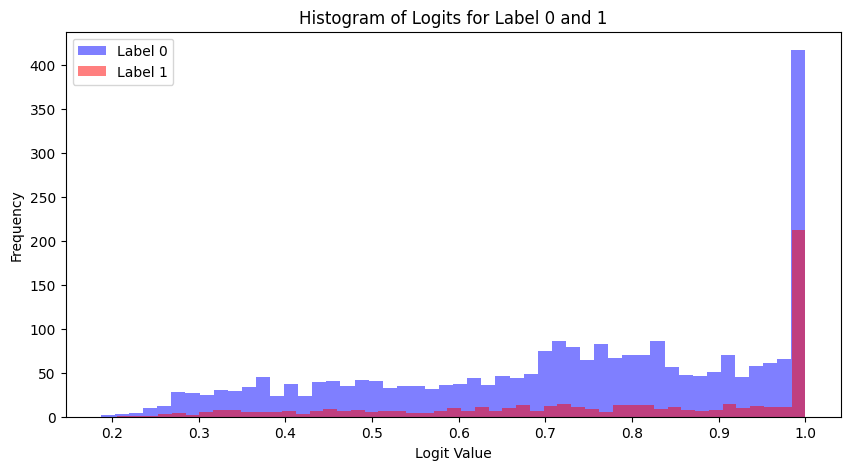

In [42]:
### plot histrogram of logits with label 0 and 1
all_logits_tensor = torch.cat(all_logits)  # Convert list of tensors to a single tensor
plt.figure(figsize=(10, 5))
plt.hist(all_logits_tensor[all_labels == 0].numpy(), bins=50, alpha=0.5, label='Label 0', color='blue')
plt.hist(all_logits_tensor[all_labels == 1].numpy(), bins=50, alpha=0.5, label='Label 1', color='red')
plt.title('Histogram of Logits for Label 0 and 1')
plt.xlabel('Logit Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

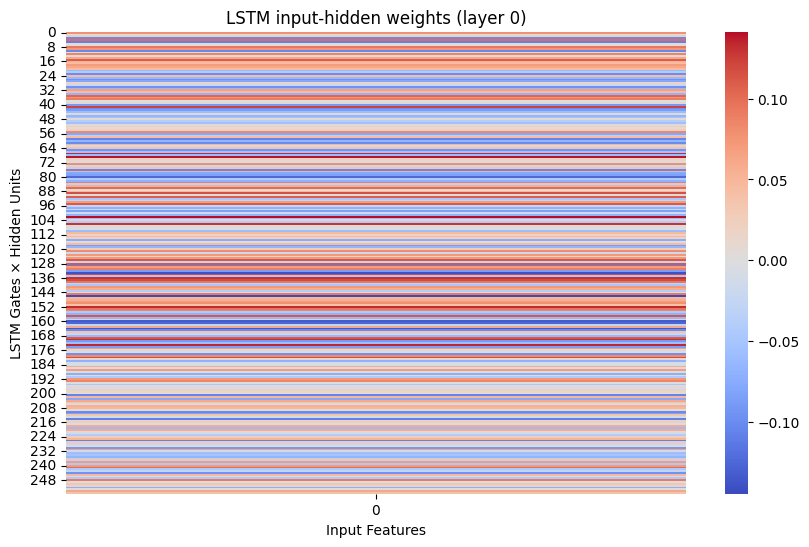

In [14]:
# Access LSTM weights (example for first layer)
lstm_weights = model.lstm.weight_ih_l0.detach().cpu().numpy()  # shape: (4*hidden_dim, input_dim)

plt.figure(figsize=(10, 6))
sns.heatmap(lstm_weights, cmap='coolwarm', center=0)
plt.title("LSTM input-hidden weights (layer 0)")
plt.xlabel("Input Features")
plt.ylabel("LSTM Gates × Hidden Units")
plt.show()


## Classifer Model

In [15]:
model.eval()
all_adjacency = []
all_labels = []

with torch.no_grad():
    loop = tqdm(train_seizure_class_loader, desc="Extracting adjacency", leave=False)
    for x_val, y_val in loop:
        x_val = x_val.to(device).float()
        y_val = y_val.to(device)

        adjacency, _ = model(x_val)  # (batch, 19, 19)
        all_adjacency.append(adjacency.cpu())   # keep batch dimension
        all_labels.append(y_val.cpu())


              precision    recall  f1-score   support

  No Seizure       0.94      0.97      0.96      2842
     Seizure       0.85      0.77      0.81       697

    accuracy                           0.93      3539
   macro avg       0.90      0.87      0.88      3539
weighted avg       0.93      0.93      0.93      3539



Text(0.5, 1.0, 'Feature Importances')

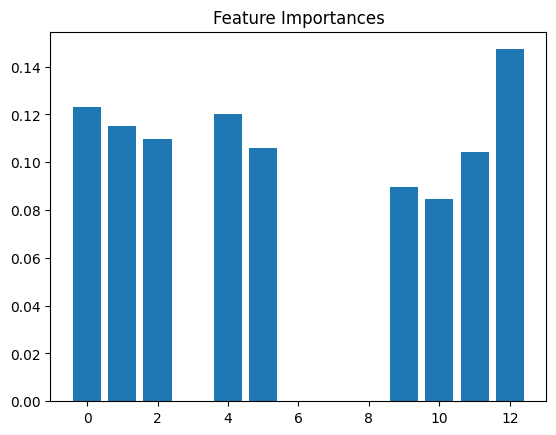

In [16]:
import numpy as np
import pandas as pd
import networkx as nx
from scipy.stats import entropy

def compute_graph_features(adj):
    np.fill_diagonal(adj, 0)  # Remove self-loops if present
    adj = (adj + 1) / 2

    degrees = adj.sum(axis=1)
    edge_weights = adj[np.triu_indices_from(adj, k=1)]

    # Use NetworkX for advanced features
    G = nx.from_numpy_array(adj)

    # Compute features
    features = {
        "mean_degree": degrees.mean(),
        "max_degree": degrees.max(),
        "min_degree": degrees.min(),
        "edge_count": np.count_nonzero(edge_weights),
        "mean_edge_weight": edge_weights.mean() if edge_weights.size > 0 else 0,
        "std_edge_weight": edge_weights.std() if edge_weights.size > 1 else 0,
        "density": nx.density(G),
        "avg_clustering": nx.average_clustering(G),
        "num_connected_components": nx.number_connected_components(G),
        "degree_entropy": entropy(degrees / (degrees.sum() + 1e-8)),
    }

    # Optionally: top-3 eigenvalues of Laplacian
    L = nx.normalized_laplacian_matrix(G).toarray()
    eigvals = np.sort(np.linalg.eigvalsh(L))
    for i in range(min(3, len(eigvals))):
        features[f"eigval_{i}"] = eigvals[i]

    return features

def extract_features_and_labels(adjacency_list, labels_list):
    """
    Convert a list of batched adjacency tensors and labels into a feature matrix and label vector.
    """
    # Step 1: Concatenate and convert to numpy
    all_adj = torch.cat(adjacency_list, dim=0).numpy()   # (N, 19, 19)
    if labels_list is not None:
        #all_adj = all_adj.reshape(-1, 19, 19)
        all_labels = torch.cat(labels_list, dim=0).numpy()   # (N,)
    else:
        all_labels = None
    # Step 2: Extract features for each adjacency matrix
    feature_dicts = [compute_graph_features(adj) for adj in all_adj]
    features_df = pd.DataFrame(feature_dicts)

    return features_df, all_labels

features_df, labels = extract_features_and_labels(all_adjacency, all_labels)

# Now use it for sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

X = features_df.values
y = labels
clf = RandomForestClassifier(n_estimators=100, class_weight='balanced',random_state=42,max_depth=10)
clf.fit(X, y)
print(classification_report(y, clf.predict(X), target_names=["No Seizure", "Seizure"]))
importances = clf.feature_importances_
plt.bar(range(len(importances)), importances)
plt.title("Feature Importances")


              precision    recall  f1-score   support

  No Seizure       0.81      0.96      0.88       971
     Seizure       0.21      0.05      0.08       227

    accuracy                           0.79      1198
   macro avg       0.51      0.50      0.48      1198
weighted avg       0.70      0.79      0.73      1198



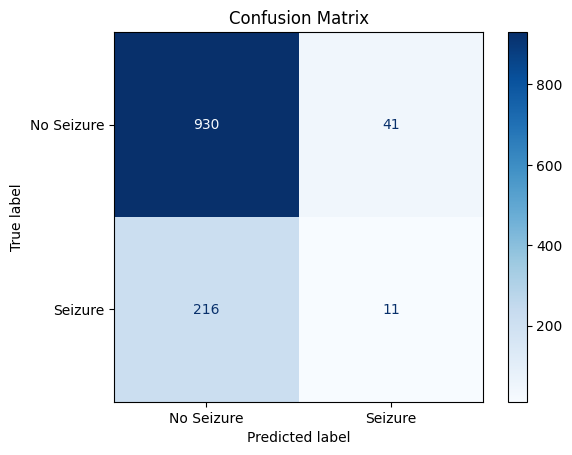

In [17]:

model.eval()
all_adjacency_2 = []
all_labels_2 = []

with torch.no_grad():
    loop = tqdm(val_loader, desc="Validation", leave=False)
    for x_val, y_val in loop:
        x_val = x_val.to(device).float()
        y_val = y_val.to(device)

        adjacency_batch, _ = model(x_val)  # (batch, 19, 19)
        
        all_adjacency_2.append(adjacency_batch.cpu())   # keep batch dimension
        all_labels_2.append(y_val.cpu())

# Extract features for validation set
features_df_val, labels_val = extract_features_and_labels(all_adjacency_2, all_labels_2)
print(classification_report(labels_val, clf.predict(features_df_val.values), target_names=["No Seizure", "Seizure"]))

# plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt


# Compute confusion matrix
cm = confusion_matrix(labels_val, clf.predict(features_df_val.values))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Seizure", "Seizure"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


## Test

In [26]:
test_data = eeg_data_wrapper.test_dataset()
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)
all_adjacency_test = []
model.eval()
all_predictions = []
all_ids = []
with torch.no_grad():
    for batch in test_loader:
        x_batch, x_ids = batch
        x_batch = x_batch.float().to(device)
        adjacency, _ = model(x_batch)  # logits: (batch,) 
        all_adjacency_test.append(adjacency.cpu())  # Store adjacency matrices
        all_ids.extend(x_ids)  # Store sample IDs
features_df_test, _ = extract_features_and_labels(all_adjacency_test, None)
all_predictions = clf.predict(features_df_test.values)
all_ids = [str(i).replace("__", "$$") for i in all_ids]
all_ids = [i.replace("_", "") for i in all_ids]
all_ids = [i.replace("$$", "_") for i in all_ids]
submission_df = pd.DataFrame({"id": all_ids, "label": all_predictions})
submission_df.to_csv("submission_custom_model.csv", index=False)
print("Kaggle submission file generated: submission.csv")

Kaggle submission file generated: submission.csv
